In [1]:
from FK import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from tqdm import tqdm
from numba import njit, prange
from time import time

In [2]:
c_wht, c_blu, c_ylw = c_sigma_unit([0,0,0], Ratio_ca=559/297.8, PBC=False)

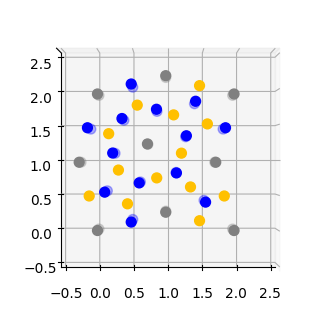

In [3]:
fig = plt.figure(figsize=(4,4))
fig.tight_layout()
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect([3,3,1])
ax.view_init(elev=90, azim=-90)

# plot particles
ax.scatter(c_wht[:,0],c_wht[:,1],c_wht[:,2],
           marker='o',c='#808080',s=50)
ax.scatter(c_blu[:,0],c_blu[:,1],c_blu[:,2],
           marker='o',c='b',s=50)
ax.scatter(c_ylw[:,0],c_ylw[:,1],c_ylw[:,2],
           marker='o',c='#FFC000',s=50)

ax.set_zticks([])
ax.set_xlim(-0.5,2.5)
ax.set_ylim(-0.5,2.5)
ax.set_zlim(0,1)
plt.show()

In [4]:
Ratio_ca=559/297.8
l = np.sqrt((1+np.sqrt(3)/2)**2+0.5**2)
l_c = l/Ratio_ca

n_x = 6
n_y = 6
n_layers = 11

c_layer_sigma = c_sigma(n_x,n_y,Ratio_ca=559/297.8)
c_rod = stack_coords([shift_coords(c_layer_sigma, np.array([0,0,l_c])*s) for s in range(n_layers)])

bounds = np.array([[0,n_x*l],[0,n_y*l],[0,n_layers*l_c]])

# FK_sigma unitcell
filename = './c_FK_sigma_6_6_11.dump'
Create_dump(c_rod,filename,boundary=bounds)

In [5]:
c_all = np.vstack(c_rod)

In [20]:
@njit
def scatter_histo(c, qq, p_sub=1.0, n_bins=1000):
    """
    Calculate scattering function.

    Args:
        c: N by 3 particle trajectory
        qq: array
            wave vectors
        p_sub: amount of particles used to calculate S(Q)
    """

    N = c.shape[1]

    # two-point correlation
    n_list = int(N*p_sub)
    i_list = np.random.choice(np.arange(N), size=n_list)
    r_jk = c[:,i_list].T.reshape(n_list,1,3) - c[:,i_list].T.reshape(1,n_list,3)
    d_jk = np.sqrt(np.sum(r_jk**2,axis=2))
    r_jk = None

    # RDF
    d_max = np.max(d_jk)
    rr = np.linspace(d_max/n_bins,d_max,n_bins)
    rho_r = np.zeros(n_bins)
    
    index_r_jk = np.floor(d_jk/d_max*n_bins) -1
    d_jk = None
    np.fill_diagonal(index_r_jk,n_bins*2) # we are not calculating these pairs
    index_f = index_r_jk.flatten()
    index_r_jk = None
    index_f = index_f[index_f!=(n_bins*2)]
    
    for i_r in range(len(index_f)):
        rho_r[int(index_f[i_r])] += 1
    
#     for i_r in tqdm(range(n_bins)):
#         rho_r[i_r] = np.sum(index_r_jk==i_r)

    S_q = np.array([np.sum(rho_r*np.sin(rr*q)/(rr*q)) for q in qq])/N + 1
    
    return S_q

In [21]:
qq = np.linspace(0.1,50,500)
N = c_all.shape[0]
rho = N/(n_x*l*n_y*l*n_layers*l_c)
r_c = 5

t_start = time()
S_q = scatter_histo(c_all.T, qq, p_sub=1.0, n_bins=1000)
t_end = time()

print(t_end-t_start)
# S_q = scatter_histo_cutoff(c_all.T, qq, rho, r_c, p_sub=1.0, n_bins=1000)

41.94953203201294


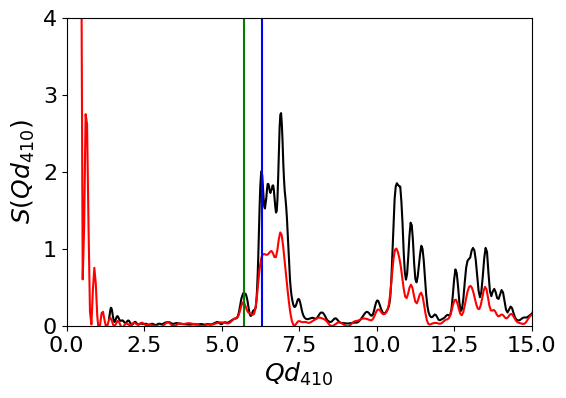

In [8]:
# FK
N = c_all.shape[0]
Ratio_ca=559/297.8
l_a = np.sqrt((1+np.sqrt(3)/2)**2+0.5**2)
l_c = l_a/Ratio_ca

l_c_s = 2*np.pi/l_c
l_a_s = 2*np.pi/l_a

d_c_s = l_c_s*np.array([0,0,1])
d_a1_s = l_a_s*np.array([1,0,0])
d_a2_s = l_a_s*np.array([0,1,0])
d_s = np.vstack([d_a1_s,d_a2_s,d_c_s])

d_410 = 2*np.pi/np.linalg.norm(np.array([4,1,0])@d_s)
Q_002 = np.linalg.norm(np.array([0,0,2])@d_s)
Q_410 = np.linalg.norm(np.array([4,1,0])@d_s)

# CYC
filename = 'SQ_FK_sigma_CYC.txt'
data = np.loadtxt(filename,skiprows=1)
d_410_C = 559/l_a*d_410

#
fig,ax = plt.subplots(1,1, figsize=[6, 4])

ax.plot(data[:,0]*d_410_C,data[:,1],'-',color='k')
ax.plot(qq*d_410,(S_q)/2,'-',color='r')
ax.plot([Q_410*d_410,Q_410*d_410],[0,40],'-',color='b')
ax.plot([Q_002*d_410,Q_002*d_410],[0,40],'-',color='g')
ax.set_xlim(0,15)
ax.set_ylim(0,4)
ax.set_xlabel('$Qd_{410}$',fontsize=18)
ax.set_ylabel('$S(Qd_{410})$',fontsize=18)
# ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [9]:
# def scatter_histo_cutoff(c, qq, rho, r_c, p_sub=1.0, n_bins=1000):
#     """
#     Calculate scattering function.

#     Args:
#         c: N by 3 particle trajectory
#         qq: array
#             wave vectors
#         r_c: cutoff distance
#         p_sub: amount of particles used to calculate S(Q)
#     """

#     N = c.shape[1]

#     # two-point correlation
#     n_list = int(N*p_sub)
#     i_list = np.random.choice(np.arange(N), size=n_list)
#     r_jk = c[:,i_list].T.reshape(n_list,1,3) - c[:,i_list].T.reshape(1,n_list,3)
#     d_jk = np.sqrt(np.sum(r_jk**2,axis=2))

#     d_max = r_c
#     dr = d_max/n_bins
#     rr = np.linspace(dr,d_max,n_bins)

#     index_r_jk = np.floor(d_jk/dr)
#     np.fill_diagonal(index_r_jk,n_bins*2) # we are not calculating these pairs
    
#     rho_r = np.zeros(n_bins)
#     for i_r in tqdm(range(n_bins)):
#         rho_r[i_r] = np.sum(index_r_jk==i_r)

#     S_q = np.array([np.sum(rho_r*np.sin(rr*q)/(rr*q)) + 4*np.pi*rho/q**3*(np.sin(r_c*q)-r_c*q*np.cos(r_c*q))
#                     for q in qq])/N + 1
    
#     return S_q